In [145]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import sys
import os
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset
We'll use the Iris dataset from sklearn. This dataset has three classes.

In [177]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
print(df.isnull().sum())
df['class'] = y

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.DataFrame(X_train, columns=feature_names)
val_df = pd.DataFrame(X_val, columns=feature_names)

numerical_features = feature_names
categorical_features = []

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


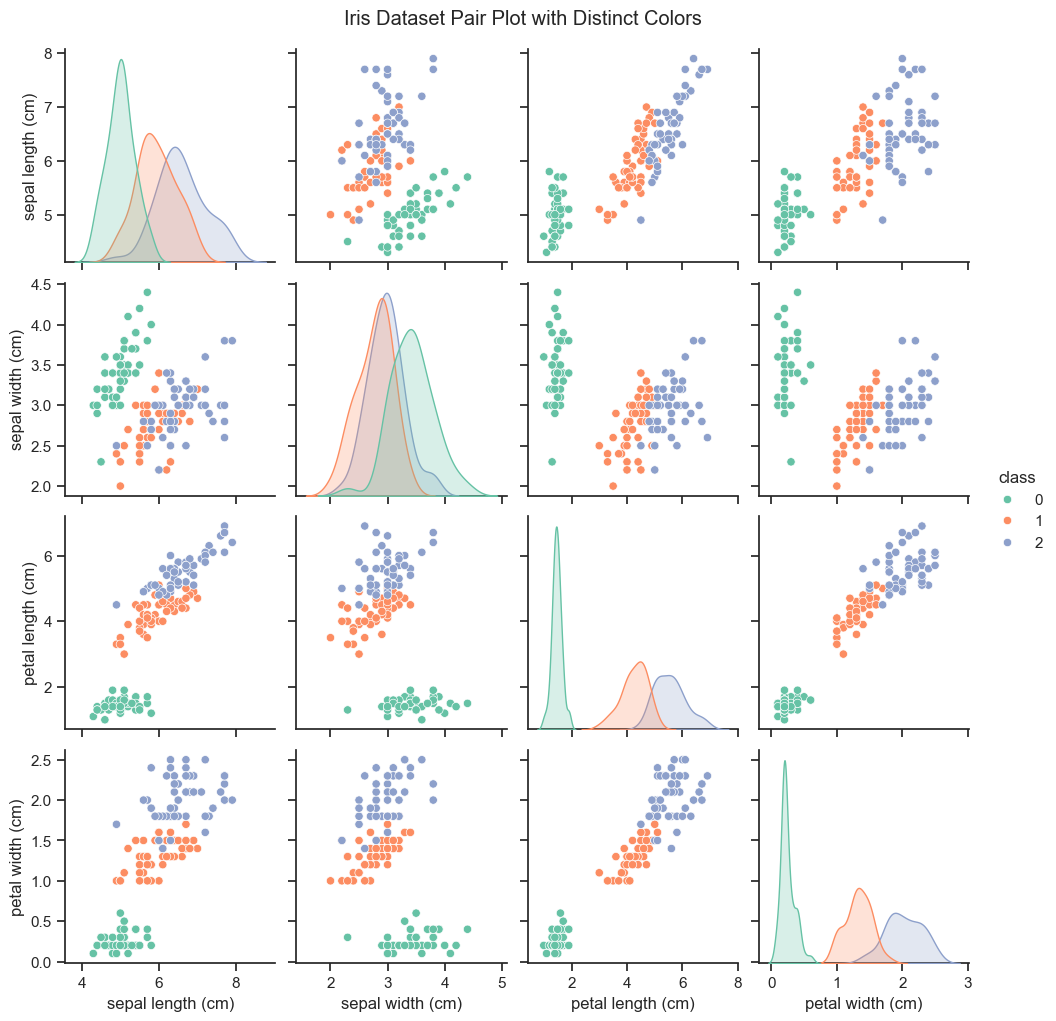

In [178]:
feature_names = iris.feature_names
class_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
df['class'] = y

# Create a pair plot for the Iris dataset with distinct colors for each class
sns.set_theme(style='ticks')

# Create a pair plot
pair_plot = sns.pairplot(df, hue='class', diag_kind='kde', palette='Set2')
pair_plot.figure.suptitle("Iris Dataset Pair Plot with Distinct Colors", y=1.02)

plt.show()

### Define Logistic Regression Model
We'll define a multiclass Logistic Regression model using PyTorch. The model will have a linear layer that maps the input features to the class scores.

In [179]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

### Define Loss

In [180]:
class LogisticRegressionLoss(nn.Module):
    def __init__(self, model, lambd):
        super(LogisticRegressionLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.model = model
        self.lambd = lambd

    def forward(self, outputs, labels):
        # Compute the cross-entropy loss
        ce_loss = self.cross_entropy(outputs, labels)

        # Compute the L2 regularization term
        l2_reg = torch.tensor(0.)
        for param in self.model.parameters():
            l2_reg += torch.norm(param)**2 

        # Combine the cross-entropy loss and the L2 regularization term
        loss = ce_loss + self.lambd * l2_reg
        return loss

### Trainig code

In [181]:
class LogisticRegressionTrainer:
    def __init__(self, num_epochs, model, criterion, optimizer, train_loader, val_loader):
        self.num_epochs = num_epochs
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            print(f'Epoch {epoch+1}/{self.num_epochs}, Training Loss: {running_loss/len(self.train_loader)}')

    def evaluate(self):
        self.model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                outputs = self.model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_labels.append(labels)
                all_preds.append(preds)

        all_labels = torch.cat(all_labels).cpu().numpy()
        all_preds = torch.cat(all_preds).cpu().numpy()

        # Extract unique class labels from the dataset
        classes = np.unique(all_labels)

        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

        print(f'Validation Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

        # Generate and display the confusion matrix
        cmTest = confusion_matrix(all_labels, all_preds, labels=classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cmTest, display_labels=classes)
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/40, Training Loss: 1.1282323867082595
Epoch 2/40, Training Loss: 0.7832897106806437
Epoch 3/40, Training Loss: 0.7204068293174107
Epoch 4/40, Training Loss: 0.6867278486490249
Epoch 5/40, Training Loss: 0.6522845427195231
Epoch 6/40, Training Loss: 0.6380103915929795
Epoch 7/40, Training Loss: 0.6037187417348225
Epoch 8/40, Training Loss: 0.5953948716322581
Epoch 9/40, Training Loss: 0.5851240237553914
Epoch 10/40, Training Loss: 0.5638191342353821
Epoch 11/40, Training Loss: 0.5537923544645309
Epoch 12/40, Training Loss: 0.5416483168800672
Epoch 13/40, Training Loss: 0.524200643102328
Epoch 14/40, Training Loss: 0.5136691088477771
Epoch 15/40, Training Loss: 0.5162232294678688
Epoch 16/40, Training Loss: 0.5069998780886332
Epoch 17/40, Training Loss: 0.5028416087230047
Epoch 18/40, Training Loss: 0.49611077407995857
Epoch 19/40, Training Loss: 0.501789257923762
Epoch 20/40, Training Loss: 0.49715413600206376
Epoch 21/40, Training Loss: 0.4906170268853505
Epoch 22/40, Training 

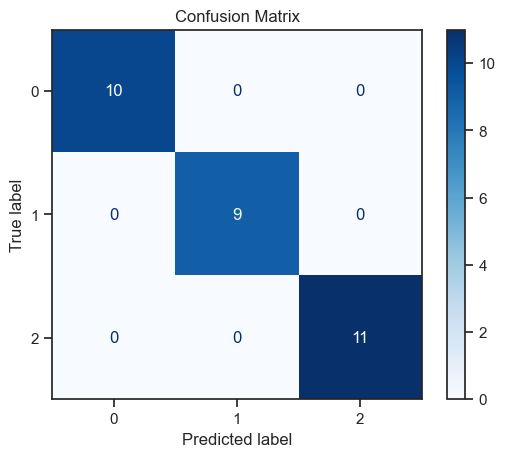

In [185]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

input_dim = len(feature_names)
num_classes = len(class_names)
model = LogisticRegressionModel(input_dim, num_classes)
num_epochs = 40
lambd = torch.tensor([0.01], requires_grad=True)

# Initialize the custom loss function
criterion = LogisticRegressionLoss(model, lambd)

# Initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Initialize the trainer
trainer = LogisticRegressionTrainer(num_epochs, model, criterion, optimizer, train_loader, val_loader)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

### Hyper Optimizer Template

In [188]:
class HyperOptimizer:
    def __init__(self, optimizer, model, criterion, val_loader, T):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.val_loader = val_loader
        self.T = T
        self.step_count = 0

    def step(self):
        self.step_count += 1
        self.optimizer.step()

        # Evaluate on validation set every T steps
        if self.step_count % self.T == 0:
            val_loss = self.evaluate()
            print(f'Step {self.step_count}, Validation Loss: {val_loss.item():.4f}')

    def evaluate(self):
        self.model.eval()
        val_loss = 0.0
        for inputs, labels in self.val_loader:
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            val_loss += loss

        val_loss /= len(self.val_loader)
        return val_loss

    def zero_grad(self):
        self.optimizer.zero_grad()

In [189]:
class HyperTrainer:
    def __init__(self, num_epochs, model, criterion, train_loader, hyper_optimizer):
        self.num_epochs = num_epochs
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.hyper_optimizer = hyper_optimizer

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                # Zero the gradients using the hyper optimizer
                self.hyper_optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()

                # Use the hyper optimizer step method
                self.hyper_optimizer.step()

                running_loss += loss.item()

            print(f'Epoch {epoch+1}/{self.num_epochs}, Training Loss: {running_loss/len(self.train_loader)}')

In [190]:
input_dim = len(feature_names)
num_classes = len(class_names)
model = LogisticRegressionModel(input_dim, num_classes)
num_epochs = 3
lambd = torch.tensor([0.01], requires_grad=True)

# Initialize the custom loss function
criterion = LogisticRegressionLoss(model, lambd)

# Initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Initialize the hyper optimizer
hyper_optimizer = HyperOptimizer(optimizer, model, criterion, val_loader, T=5)

# Initialize the trainer
trainer = HyperTrainer(num_epochs, model, criterion, train_loader, hyper_optimizer)

# Train the model
trainer.train()

# Evaluate the model
final_val_loss = trainer.hyper_optimizer.evaluate()
print(f'Final Validation Loss: {final_val_loss.item():.4f}')

Step 5, Validation Loss: 1.3756
Step 10, Validation Loss: 1.2471
Step 15, Validation Loss: 1.1672
Step 20, Validation Loss: 1.1420
Step 25, Validation Loss: 1.1211
Step 30, Validation Loss: 1.0561
Epoch 1/3, Training Loss: 1.2211749831835428
Step 35, Validation Loss: 1.0248
Step 40, Validation Loss: 1.0216
Step 45, Validation Loss: 1.0238
Step 50, Validation Loss: 0.9753
Step 55, Validation Loss: 0.9355
Step 60, Validation Loss: 0.9374
Epoch 2/3, Training Loss: 0.9947454770406087
Step 65, Validation Loss: 0.8902
Step 70, Validation Loss: 0.8839
Step 75, Validation Loss: 0.8404
Step 80, Validation Loss: 0.8297
Step 85, Validation Loss: 0.8240
Step 90, Validation Loss: 0.8519
Epoch 3/3, Training Loss: 0.8936356822649638
Final Validation Loss: 0.8519


### T1-T2

Step 5, Validation Loss: 1.5236
Step 10, Validation Loss: 1.3155
Step 15, Validation Loss: 1.0787
Step 20, Validation Loss: 1.1671
Step 25, Validation Loss: 1.0486
Step 30, Validation Loss: 0.9364
Epoch 1/3, Training Loss: 1.2469525456428527
Step 35, Validation Loss: 0.9061
Step 40, Validation Loss: 0.9093
Step 45, Validation Loss: 0.9935
Step 50, Validation Loss: 0.8760
Step 55, Validation Loss: 0.8362
Step 60, Validation Loss: 0.8189
Epoch 2/3, Training Loss: 0.879302853345871
Step 65, Validation Loss: 0.7874
Step 70, Validation Loss: 0.7930
Step 75, Validation Loss: 0.8486
Step 80, Validation Loss: 0.7631
Step 85, Validation Loss: 0.7402
Step 90, Validation Loss: 0.7191
Epoch 3/3, Training Loss: 0.8010860959688823
Final Validation Loss: 0.7191


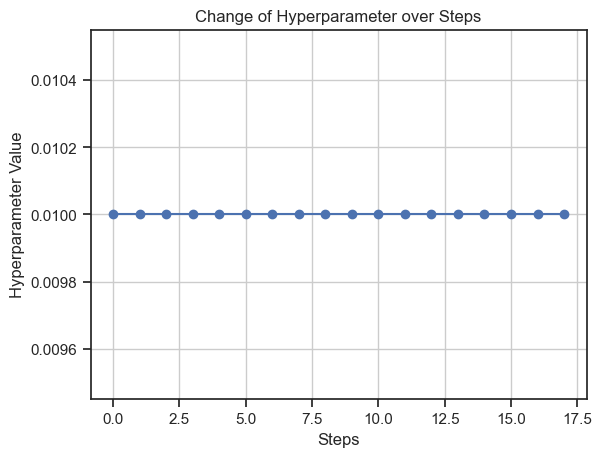

In [195]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

class HyperOptimizer:
    def __init__(self, optimizer, model, criterion, val_loader, T, hyper_lr, hyperparams):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.val_loader = val_loader
        self.T = T
        self.step_count = 0
        self.hyper_lr = hyper_lr
        self.hyperparams = hyperparams
        self.hyperparam_history = []  # Список для хранения значений гиперпараметра

    def step(self):
        self.step_count += 1
        self.optimizer.step()

        # Evaluate on validation set every T steps
        if self.step_count % self.T == 0:
            val_loss = self.evaluate()
            print(f'Step {self.step_count}, Validation Loss: {val_loss.item():.4f}')
            self.update_hyperparams()

    def evaluate(self):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss

        val_loss /= len(self.val_loader)
        return val_loss

    def zero_grad(self):
        self.optimizer.zero_grad()

    def update_hyperparams(self):
        self.model.eval()
        val_loss = 0.0
        for inputs, labels in self.val_loader:
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            val_loss += loss

        val_loss /= len(self.val_loader)
        val_loss.backward()

        for name, param in self.hyperparams.items():
            if name.startswith('model'):
                hyper_grad = torch.autograd.grad(val_loss, param, retain_graph=True)[0]
                param.data -= self.hyper_lr * hyper_grad
            elif name.startswith('criterion'):
                hyper_grad = torch.autograd.grad(val_loss, param, retain_graph=True)[0]
                param.data -= self.hyper_lr * hyper_grad

        # Сохраняем значение гиперпараметра
        self.hyperparam_history.append(param.item())

class HyperTrainer:
    def __init__(self, num_epochs, model, criterion, train_loader, hyper_optimizer):
        self.num_epochs = num_epochs
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.hyper_optimizer = hyper_optimizer

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                # Zero the gradients using the hyper optimizer
                self.hyper_optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()

                # Use the hyper optimizer step method
                self.hyper_optimizer.step()

                running_loss += loss.item()

            print(f'Epoch {epoch+1}/{self.num_epochs}, Training Loss: {running_loss/len(self.train_loader)}')

# Пример использования
input_dim = len(feature_names)
num_classes = len(class_names)
model = LogisticRegressionModel(input_dim, num_classes)
num_epochs = 3
lambd = torch.tensor([0.01], requires_grad=True)

# Initialize the custom loss function
criterion = LogisticRegressionLoss(model, lambd)

# Initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Initialize the hyper optimizer
hyper_optimizer = HyperOptimizer(optimizer, model, criterion, val_loader, T=5, hyper_lr=0.1, hyperparams={'lambd': lambd})

# Initialize the trainer
trainer = HyperTrainer(num_epochs, model, criterion, train_loader, hyper_optimizer)

# Train the model
trainer.train()

# Evaluate the model
final_val_loss = trainer.hyper_optimizer.evaluate()
print(f'Final Validation Loss: {final_val_loss.item():.4f}')

# Построение графика изменения гиперпараметра
steps = list(range(len(trainer.hyper_optimizer.hyperparam_history)))
hyperparam_values = trainer.hyper_optimizer.hyperparam_history

plt.plot(steps, hyperparam_values, marker='o')
plt.xlabel('Steps')
plt.ylabel('Hyperparameter Value')
plt.title('Change of Hyperparameter over Steps')
plt.grid(True)
plt.show()